In [55]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
from sklearn.preprocessing import normalize

In [86]:
IMAGE_PATH = "Image.jpg"

In [89]:
image = np.array(PIL.Image.open(IMAGE_PATH))

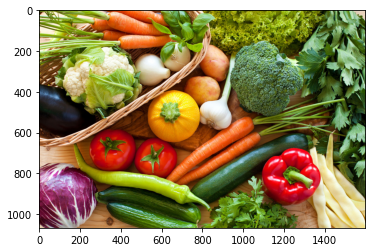

In [90]:
plt.imshow(image)

In [5]:
def get_data(file_path, delim):
    with open(file_path) as f:
        features = np.array(list(map(lambda x : list(map(float, x.strip().split(delim))),f.readlines())))
    return features

In [77]:
data = np.append(get_data("non-linear-data/Class1.txt","\t"), get_data("non-linear-data/Class2.txt","\t"),0)

In [110]:
import matplotlib.pyplot as plt
import numpy as np
import numba as nb
import time


class Point(np.ndarray):
    def __new__(self, *args, **kwargs):
        return super(Point, self).__new__(self, *args, **kwargs)
    def __array_finalize__(self, obj):
        self.cluster = -1
    def set_id(self, id):
        self.id = id

def convert2point(array, id):
    new = array.view(Point)
    new.set_id(id)
    return new

def get_points(data):
    new_data = []
    for i, p in enumerate(data):
        new_data.append(convert2point(p, i))
    return new_data

def get_components(data):
    components = [[] for i in range(len(data[0]))]
    for i in data:
        for j in range(len(i)):
            components[j].append(i[j])
    return components

class Kmeans:

    def __init__(self, k, input_shape, distance_function=lambda x, y : np.linalg.norm(x-y)):
        # initializing centers using normal distribution
        self.centers = np.random.normal(0., 1., size=(k, input_shape)) 
        self.points = [ set() for i in range(k) ]
        self.distance_function = distance_function
        self.k = k
        self.input_shape = input_shape
        self.data = None
        self.union_buffer = [ set() for i in range(k)]

    def fit(self, data, iterations=300): # data list of Points
        self.data = data

        for point in data:
            distances = np.zeros(self.k, dtype=float)
            for i, center in enumerate(self.centers):
                distances[i] = self.distance_function(point, center)
            cluster_id = np.argmin(distances)
            self.points[cluster_id].add(point.id)
            self.data[point.id].cluster = cluster_id

        for i in range(iterations):
            s_time = time.time()
            self.union_buffer = [ set() for i in range(self.k) ]
            for cluster_id in range(self.k):
                self.resolve_cluster(cluster_id)
            for cluster_id in range(self.k):
                self.points[cluster_id].union(self.union_buffer[cluster_id])
            e_time = time.time()
            print(f"Iteration {i+1} : {round(e_time-s_time, 2)}")
        

    def resolve_point(self, point: Point):
        distances = np.zeros(self.k, dtype=float)
        for i, center in enumerate(self.centers):
            distances[i] = self.distance_function(point, center)
        new_cluster = np.argmin(distances)
        if point.cluster == new_cluster:
            return
        if point.cluster != -1:
            self.points[point.cluster].remove(point.id)
        self.points[new_cluster].add(point.id)
        point.cluster = new_cluster

    def get_mean(self, cluster_id):
        ans = np.zeros(self.input_shape, float)
        if not self.points[cluster_id]:
            return self.centers[cluster_id] 
        for point_id in self.points[cluster_id]:
            ans += self.data[point_id]
        return ans/len(self.points[cluster_id])

    def resolve_cluster(self, cluster_id : int):
        # print(self.get_mean(cluster_id))
        self.centers[cluster_id] = self.get_mean(cluster_id)
        remove_points = []
        for point_id in self.points[cluster_id]:
            distances = np.zeros(self.k, dtype=float)
            for i, center in enumerate(self.centers):
                distances[i] = self.distance_function(self.data[point_id], center)
            new_cluster = np.argmin(distances)
            if new_cluster == cluster_id:
                continue
            self.union_buffer[new_cluster].add(point_id)
            remove_points.append(point_id)
            self.data[point_id].cluster = new_cluster
        for i in remove_points:
            self.points[cluster_id].remove(i)
        self.centers[cluster_id] = self.get_mean(cluster_id)
        
    def plot_cluster(self, cluster_id):
        for point_id in self.points[cluster_id]:
            plt.scatter(*self.data[point_id], c=cluster_id)
    
    def plot(self):
        components = get_components(self.data)
        labels = [ i.cluster for i in self.data ]
        plt.scatter(*components, c=labels)
        for i in self.centers:
            plt.scatter(*i,c='black',s=50)
    

        

In [105]:
def solve_for_data(data):
    model = Kmeans(2, data.shape[-1])
    model.fit(get_points(data), iterations=10)
    model.plot()

Iteration 1 : 0.05
Iteration 2 : 0.04
Iteration 3 : 0.04
Iteration 4 : 0.04
Iteration 5 : 0.04
Iteration 6 : 0.04
Iteration 7 : 0.04
Iteration 8 : 0.04
Iteration 9 : 0.04
Iteration 10 : 0.04


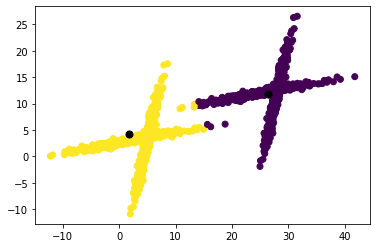

In [111]:
solve_for_data(data)

In [112]:
def preprocess1(image):
    x, y, z = image.shape
    data = []
    for i in range(x):
        for j in range(y):
            data.append(image[i][j])
    return np.array(data, dtype=float)

In [113]:
img_data = preprocess1(image)

In [114]:
solve_for_data(img_data)

KeyboardInterrupt: 